In [1]:
# !pip install pmdarima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from  scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import datetime
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
# function for mape
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [2]:
df = pd.read_csv('order_fe_status_08-07-2021.csv')
df = df[df.grass_date != '9999-01-01']
df.reset_index(inplace=True, drop=True)
df['grass_date']= pd.to_datetime(df['grass_date'])
df = df.set_index(['grass_date'])
df = df.sort_index()

<AxesSubplot:xlabel='status'>

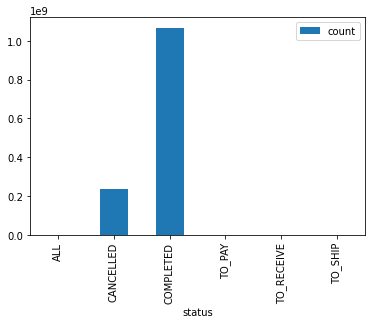

In [3]:
dff = pd.DataFrame()
dff['count'] = df['count'].copy()
dff['status'] = df['order_fe_status']
dff = dff.groupby(['status']).sum().reset_index()
dff.plot.bar(x='status', y='count')

In [4]:
status = ['CANCELLED','COMPLETED']
df_com = df.loc[df['order_fe_status'].isin(status)]
cancel = df_com[df_com['order_fe_status']=='CANCELLED']
cancel.drop('order_fe_status', axis=1, inplace=True)
cancel.rename(columns={'count':'cancel'}, inplace=True)

complete = df_com[df_com['order_fe_status']=='COMPLETED']
complete.drop('order_fe_status', axis=1, inplace=True)
complete.rename(columns={'count':'complete'}, inplace=True)


C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
df1=pd.DataFrame()
df1['date'] = df_com.index.copy()
df1 = df1.set_index(['date'])
df1['complete'] = complete
df1['cancel'] = cancel
df1.fillna(0, inplace=True)
df1 = df1[df1.index.duplicated(keep='first')]
rate = df1['complete']/(df1['complete']+df1['cancel']) # complete rate calculation
df1['net_rate']=rate
net_rate = df1.drop(['complete','cancel'],axis=1)
# net_rate = net_rate[net_rate.index>='2018-01-01']
net_rate

,net_rate
date,
2015-05-25,0.266667
2015-06-02,0.222222
2015-06-03,0.285714
2015-06-04,0.724138
2015-06-05,0.473684
...,...
2021-07-03,0.857004
2021-07-04,0.849715
2021-07-05,0.850116


In [6]:
net_rate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2163 entries, 2015-05-25 to 2021-07-07
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   net_rate  2163 non-null   float64
dtypes: float64(1)
memory usage: 33.8 KB


# Data Visualisation

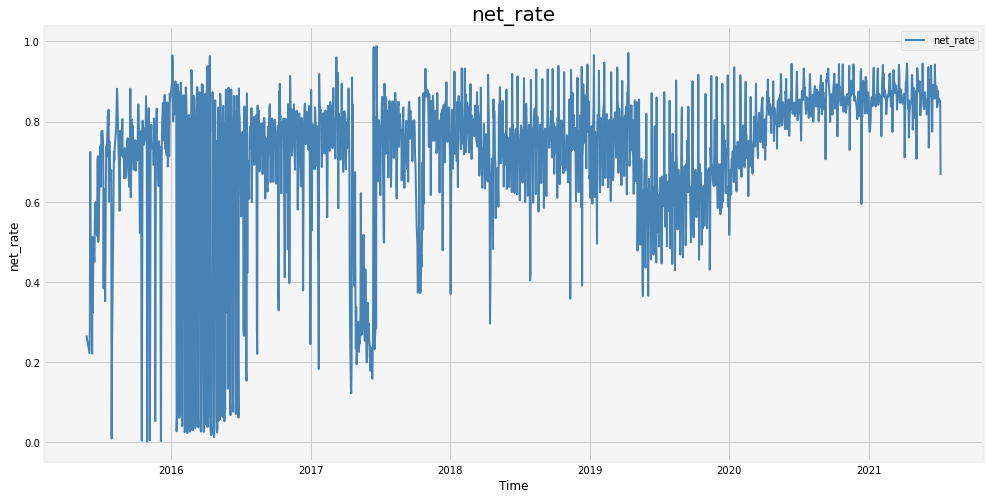

In [9]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(net_rate,label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
#plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

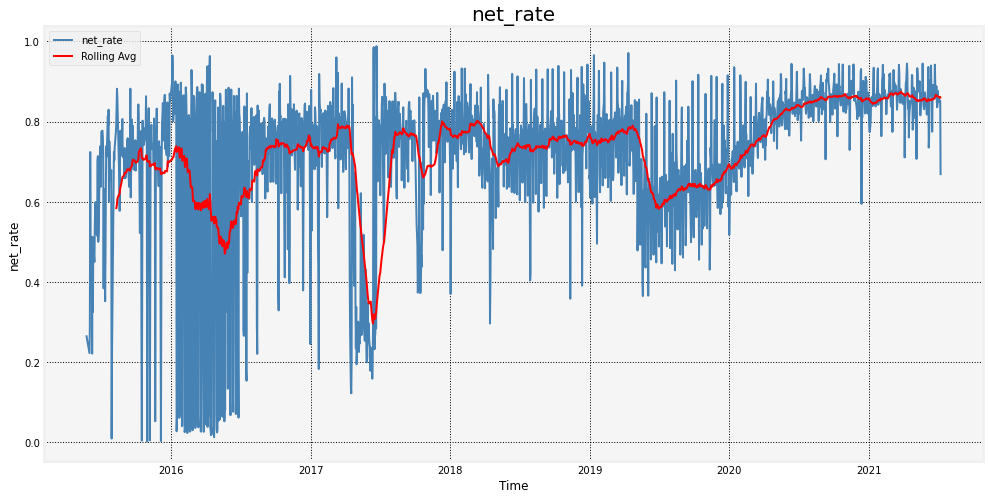

In [10]:
# Rolling Average
df_roll = net_rate.rolling(window=50).mean()

# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(net_rate,label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(df_roll['net_rate'], label = 'Rolling Avg', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

# Exploration Data Analysis (EDA)

C:\Users\mizte\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


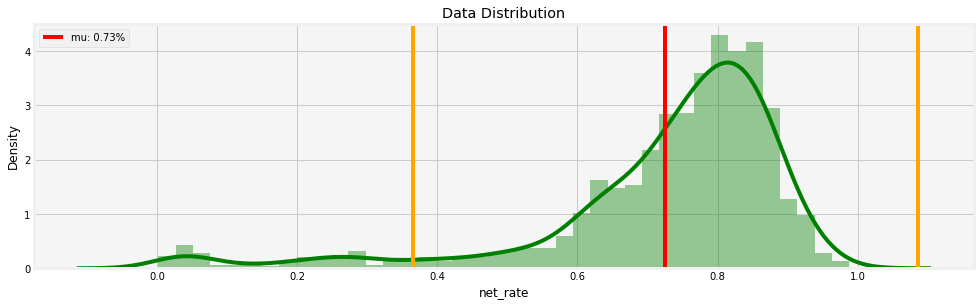

In [11]:
# Plot Distribution

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 4.5) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color

sns.distplot(net_rate['net_rate'],color='g')

plt.title("Data Distribution")
plt.xlabel("net_rate")

mean = np.mean(net_rate['net_rate'])
std = np.std(net_rate['net_rate'])
plt.axvline(x=mean, color='r', linestyle='-', label="mu: {0:.2f}%".format(mean))
plt.axvline(x=mean+2*std, color='orange', linestyle='-')
plt.axvline(x=mean-2*std, color='orange', linestyle='-')
# plt.grid(color="k", linestyle=":") # set grid and line shape
plt.legend()
plt.show()

<ipython-input-12-61a0083caa00>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = seasonal_decompose(net_rate, model='additive',freq=30)


Text(0, 0.5, 'seasonal')

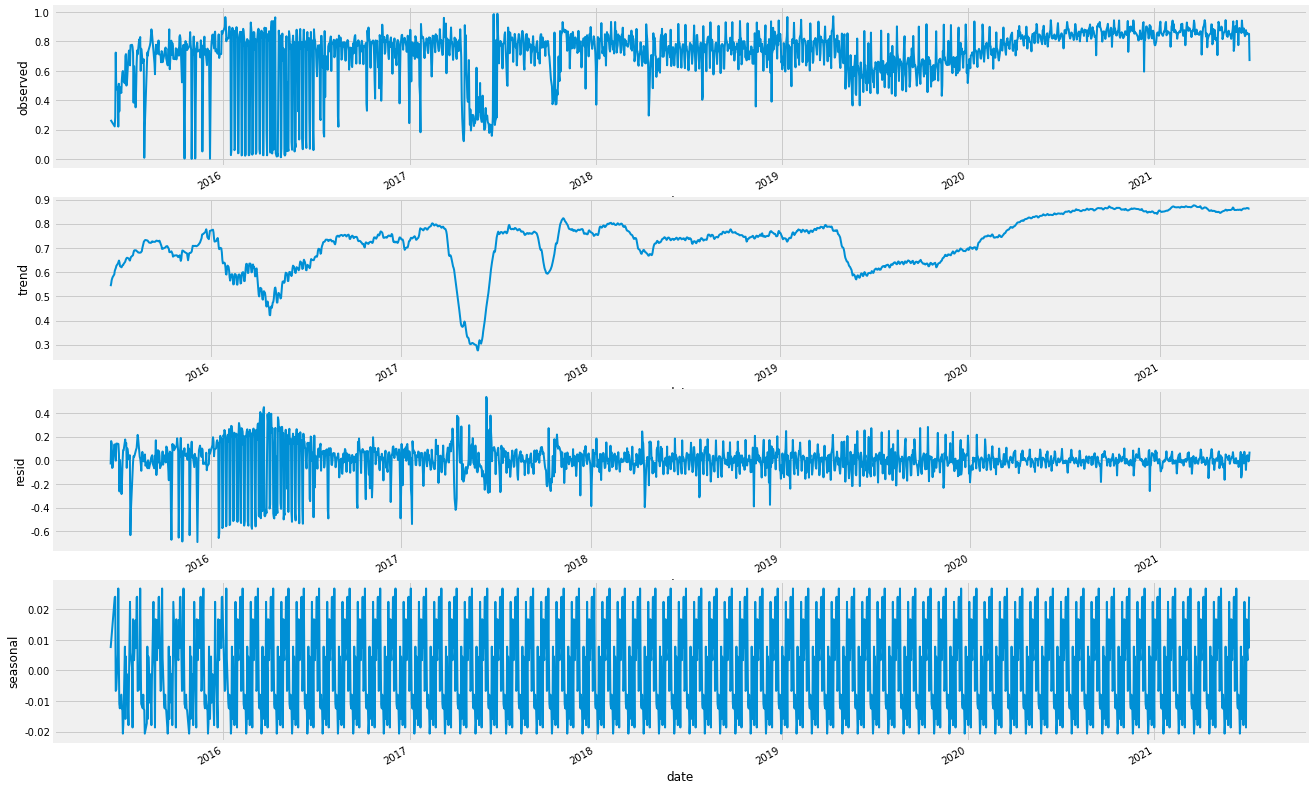

In [12]:
# Data decomposition
res = seasonal_decompose(net_rate, model='additive',freq=30)
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,15))
res.observed.plot(ax=ax1,linewidth=2)
ax1.set_ylabel('observed')
res.trend.plot(ax=ax2,linewidth=2)
ax2.set_ylabel('trend')
res.resid.plot(ax=ax3,linewidth=2)
ax3.set_ylabel('resid')
res.seasonal.plot(ax=ax4,linewidth=2)
ax4.set_ylabel('seasonal')

# Exponential Smoothing

In [13]:
# simple exponential smoothing(one-step-ahead-prediction)
def mape(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
def sse(x, y):
    return np.sum(np.power(x-y,2))

alphas = np.arange(0.01,1,0.001)
sse_al = []
for alpha_i in alphas:
  ses_i = net_rate.ewm(alpha = alpha_i, adjust=False).mean()
  sse_al.append(sse(net_rate[1:].values, ses_i[:-1].values))
alpha_opt = alphas[np.argmin(sse_al)]
print(" Optimal Alpha for 1 - step forecast: {:.3f}".format(alpha_opt))

 Optimal Alpha for 1 - step forecast: 0.116


            net_rate  net_rate_exp
date                              
2015-05-25  0.266667      0.266667
2015-06-02  0.222222      0.257778
2015-06-03  0.285714      0.263365
2015-06-04  0.724138      0.355520
2015-06-05  0.473684      0.379153
...              ...           ...
2021-07-02  0.848371      0.860005
2021-07-03  0.857004      0.859405
2021-07-04  0.849715      0.857467
2021-07-05  0.850116      0.855997
2021-07-06  0.851735      0.855144

[2162 rows x 2 columns]


<AxesSubplot:title={'center':'ses vs actual'}, xlabel='date'>

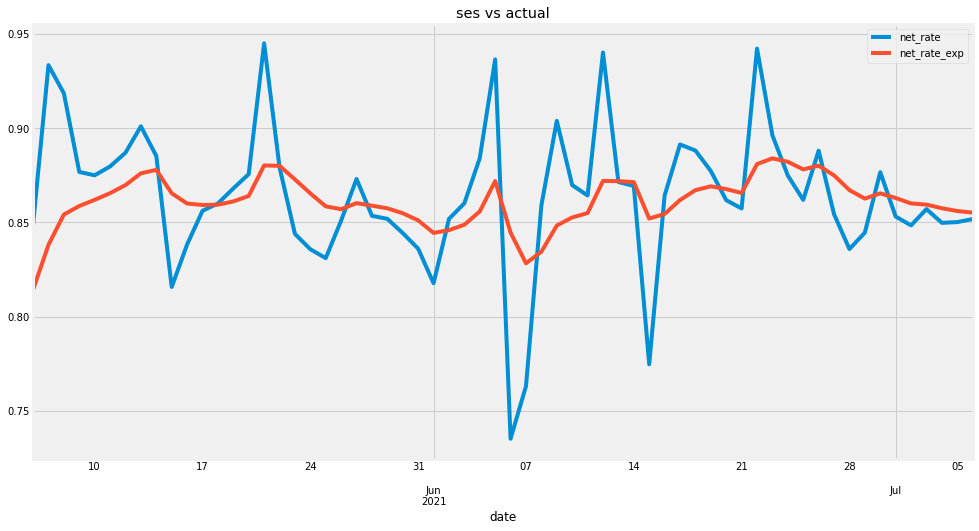

In [66]:
y = net_rate['net_rate'][:len(net_rate)-1]
y = y.reset_index(drop=True)

alpha_opt = 0.2
a = alpha_opt

lt_manual = [y[0]] # l0 = first observation
prediction=[] # obtain prediction values
count=0
for t in range(1,len(y)+1):
    count=count+1
    # Calculate smoothed value at time t
    if t < len(y):
        l_t = a*y[t]+(1-a)*lt_manual[t-1]
        lt_manual.append(l_t)
    else:
        yp=l_t
        pred = a*yp+(1-a)*lt_manual[t-1] # make prediction
        prediction.append(pred)

df2 = net_rate[net_rate.index!='2021-07-07']
df2 = df2.reset_index()
df2['net_rate_exp'] = lt_manual
df2.set_index('date',inplace=True)
print(df2)
df2[2100:].plot(title='ses vs actual')

In [15]:
actual = net_rate['net_rate']['2021-07-07']
d = {'grass_date':'2021-07-07', 'actual': [actual], 'prediction': prediction}
result = pd.DataFrame(d)
result.set_index(['grass_date'], inplace=True)
result

,actual,prediction
grass_date,,
2021-07-07,0.666483,0.855144


# ARIMA

In [16]:
plen = 30
Arima_data = net_rate.copy()
Arima_validation_data = net_rate[-plen:]
Arima_train_data = net_rate[:-plen]

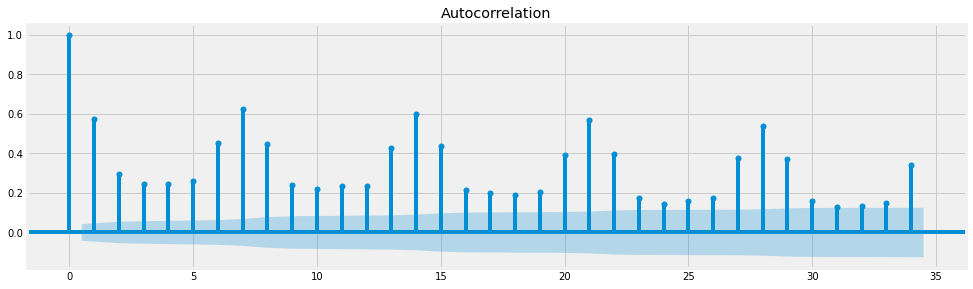

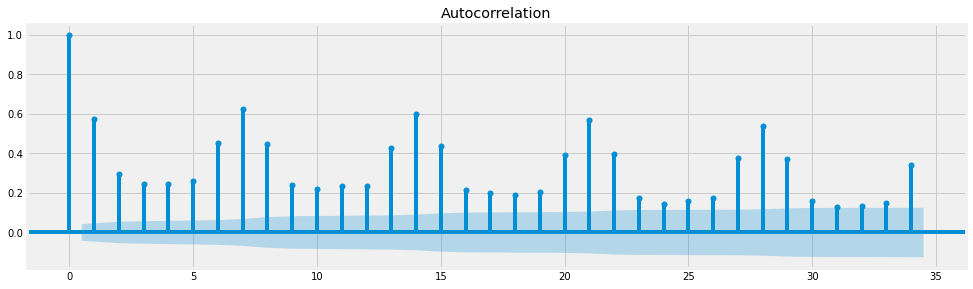

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(Arima_data)

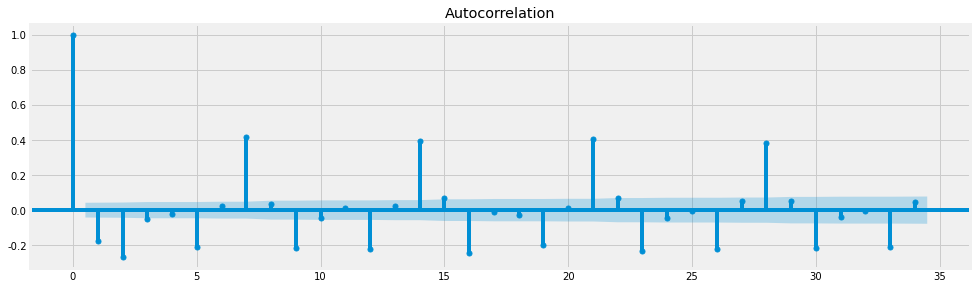

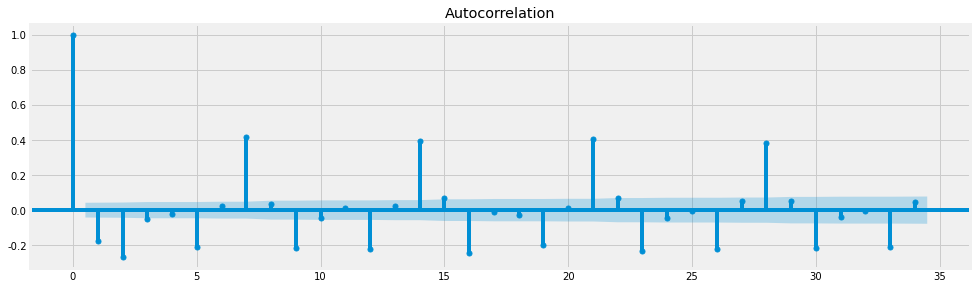

In [18]:
data_diff = Arima_data.diff(periods=1)
data_diff = data_diff[1:]
plot_acf(data_diff) # integrate of order 1, denoted by d(for diff), one of the parameter of ARIMA

In [19]:

stepwise_model = auto_arima(Arima_train_data, start_p=0, start_q=0,
                           max_p=2, max_q=2, m=7,
                           start_P=0,start_Q=0,max_Q=2,max_P=2,seasonal=True,d=1, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1562.470, Time=0.31 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-2142.625, Time=0.78 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-2303.342, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1564.466, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-2027.160, Time=0.48 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-2951.847, Time=2.34 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-2481.617, Time=1.07 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-2964.149, Time=4.92 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-2690.713, Time=2.72 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-2955.911, Time=12.35 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-2965.224, Time=11.61 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-2454.403, Time=7.37 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-2369.619, Time=3.20 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=-2984.633, Time=13.03 sec
 ARIMA(1,1,1)(0,

In [75]:
stepwise_model.fit(Arima_train_data)
forecast = stepwise_model.predict(n_periods=len(Arima_validation_data))
forecast = pd.DataFrame(forecast, index = Arima_validation_data.index, columns = ['forecast'])
forecast['actual']=Arima_validation_data
# forecast

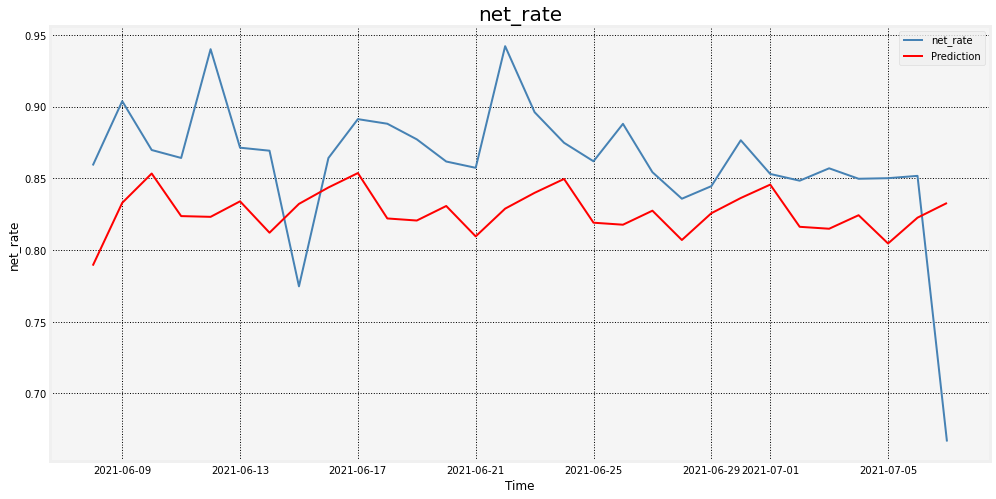

In [76]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

In [72]:
# Metrics

# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.003572
rmse,0.059763
mae,0.049904
mape,6.052558
mdae,0.041342
mdape,4.804236


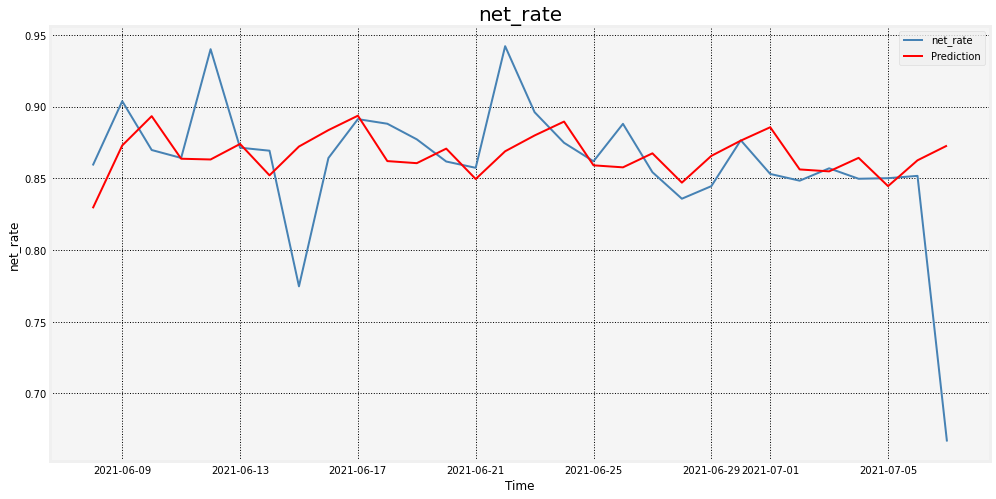

,metrics
mse,0.002373
rmse,0.048714
mae,0.027447
mape,3.160483
mdae,0.015508
mdape,1.762751


In [87]:
# error adjust(shift up)
error_adj_arima = 0.04
forecast['adj forecast']=forecast['forecast']+error_adj_arima

# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['adj forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

# Metrics

# root mean squared error
mse = mean_squared_error(forecast['adj forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['adj forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['adj forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['adj forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['adj forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['adj forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

# Future Prediction with ARIMA

In [23]:
Arima_data = net_rate.copy()
Arima_train_data = net_rate.copy()
Arima_plot_data = net_rate[-14:]

In [24]:

stepwise_model = auto_arima(Arima_train_data, start_p=0, start_q=0,
                           max_p=4, max_q=4, m=7,
                           start_P=0,start_Q=0,max_Q=4,max_P=4,seasonal=True,d=1, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1611.504, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-2197.474, Time=0.76 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-2362.071, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-1613.501, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-2082.825, Time=0.54 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-2931.564, Time=1.84 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-2542.126, Time=0.78 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-2934.488, Time=4.75 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-2753.920, Time=2.87 sec
 ARIMA(0,1,1)(3,0,1)[7] intercept   : AIC=-3015.831, Time=16.41 sec
 ARIMA(0,1,1)(3,0,0)[7] intercept   : AIC=-2883.273, Time=12.19 sec
 ARIMA(0,1,1)(4,0,1)[7] intercept   : AIC=-3011.251, Time=21.37 sec
 ARIMA(0,1,1)(3,0,2)[7] intercept   : AIC=-3019.789, Time=17.09 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-3022.408, Time=13.07 sec
 ARIMA(0,1,1)(

In [63]:
start_date = datetime.date(2021, 7 , 8)
number_of_days = 20

date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date_list = pd.DataFrame(date_list, columns = ['date'])
# date_list # prediction date

In [61]:
stepwise_model.fit(Arima_train_data)
future = stepwise_model.predict(n_periods= number_of_days)
future = pd.DataFrame(future, index = date_list.date, columns = ['future'])
future.index= pd.to_datetime(future.index)
future

,future
date,
2021-07-08,0.789146
2021-07-09,0.832934
2021-07-10,0.853362
2021-07-11,0.823678
2021-07-12,0.823161
2021-07-13,0.833981
2021-07-14,0.812104
2021-07-15,0.832196
2021-07-16,0.843637


<AxesSubplot:title={'center':'Future Net Rate'}, xlabel='date'>

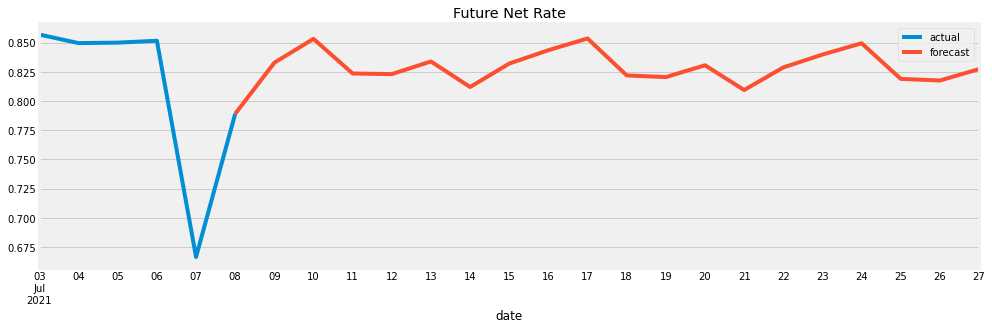

In [62]:
future.rename(columns={'future':'net_rate'}, inplace=True)
Arima_plot = Arima_plot_data.append(future.head(1))
Arima_plot.rename(columns={'net_rate':'actual'}, inplace=True)
future.rename(columns={'net_rate':'forecast'}, inplace=True)
pd.concat([Arima_plot[9:],future],axis=1).plot(title = 'Future Net Rate',figsize=(15, 4.5))

C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


<AxesSubplot:title={'center':'Future Net Rate'}, xlabel='date'>

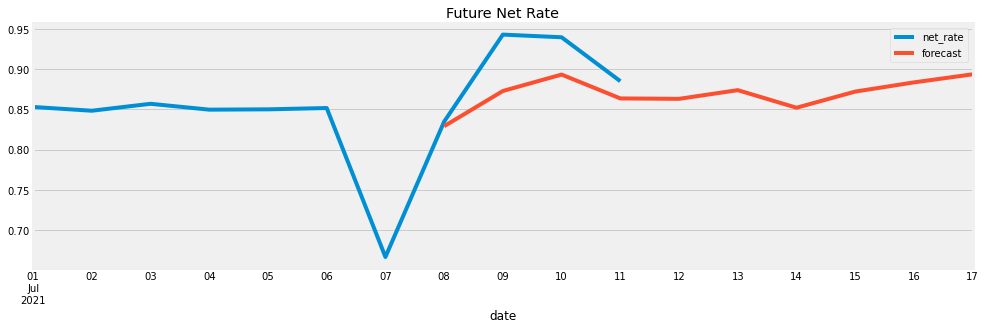

In [88]:
# update data
update = pd.read_csv('order_fe_status_12jul21.csv')
update = update[update.grass_date != '9999-01-01']
update.reset_index(inplace=True, drop=True)
update['grass_date']= pd.to_datetime(update['grass_date'])
update = update.set_index(['grass_date'])
update = update.sort_index()

status = ['CANCELLED','COMPLETED']
update_com = update.loc[update['order_fe_status'].isin(status)]
up_cancel = update_com[update_com['order_fe_status']=='CANCELLED']
up_cancel.drop('order_fe_status', axis=1, inplace=True)
up_cancel.rename(columns={'count':'cancel'}, inplace=True)

up_complete = update_com[update_com['order_fe_status']=='COMPLETED']
up_complete.drop('order_fe_status', axis=1, inplace=True)
up_complete.rename(columns={'count':'complete'}, inplace=True)

up1=pd.DataFrame()
up1['date'] = update_com.index.copy()
up1 = up1.set_index(['date'])
up1['complete'] = up_complete
up1['cancel'] = up_cancel
up1.fillna(0, inplace=True)
up1 = up1[up1.index.duplicated(keep='first')]
up_rate = up1['complete']/(up1['complete']+up1['cancel']) # complete rate calculation
up1['net_rate']=up_rate
up_net_rate = up1.drop(['complete','cancel'],axis=1)

pd.concat([up_net_rate[-11:],future[:-10]+error_adj_arima],axis=1).plot(title = 'Future Net Rate',figsize=(15, 4.5))

# Holt Winters Exponential Smoothing

In [36]:
hw_data = net_rate.copy()
hw_validation_data = net_rate[-plen:]
hw_train_data = net_rate[:-plen]

C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:title={'center':'Validation Net Rate'}, xlabel='date'>

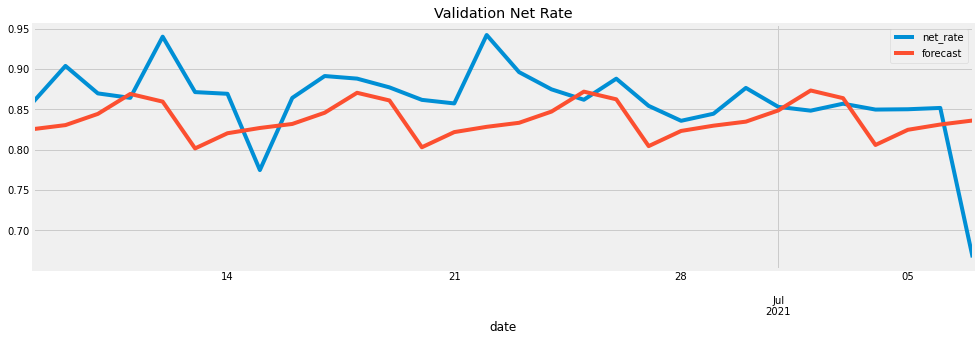

In [89]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(hw_train_data,trend='add',
                                    seasonal='add',seasonal_periods=7).fit()
predictions = fitted_model.forecast(len(hw_validation_data)).rename('forecast')
forecast = pd.DataFrame(predictions)
forecast.index = hw_validation_data.index
pd.concat([hw_validation_data['net_rate'],forecast],axis=1).plot(title = 'Validation Net Rate',figsize=(15, 4.5))

In [90]:
forecast['actual'] = hw_validation_data['net_rate']
# Metrics

# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.002919
rmse,0.054024
mae,0.041640
mape,5.008802
mdae,0.032904
mdape,3.819235


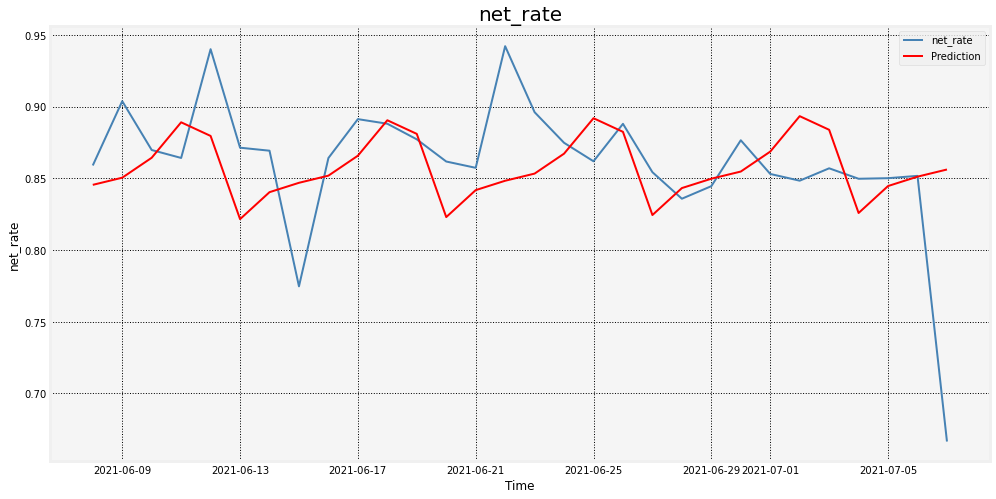

,metrics
mse,0.002369
rmse,0.048676
mae,0.031934
mape,3.736421
mdae,0.024362
mdape,2.834824


In [93]:
# error adjust (shift up)
error_adj_hw= 0.02
forecast['adj forecast']=forecast['forecast']+error_adj_hw
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['adj forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

# Metrics

# root mean squared error
mse = mean_squared_error(forecast['adj forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['adj forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['adj forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['adj forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['adj forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['adj forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

# Random Forest Regression

In [39]:
ran_data = net_rate.copy()
ran_val_data = net_rate[-plen:]
ran_train_data = net_rate[:-plen]

In [40]:
# forecast monthly births with random forest
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%f, predicted=%f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

# load the dataset
series = ran_data
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6) # look back 6 days to make tomorrow's prediction
# evaluate
mae, y, yhat = walk_forward_validation(data, plen)
print('MAE: %.3f' % mae)
# plot expected vs predicted
# pyplot.plot(y, label='Expected')
# pyplot.plot(yhat, label='Predicted')
# pyplot.legend()
# pyplot.show()

>expected=0.858985, predicted=0.781410
>expected=0.903822, predicted=0.849099
>expected=0.869760, predicted=0.879772
>expected=0.864224, predicted=0.850963
>expected=0.940065, predicted=0.798879
>expected=0.871377, predicted=0.871915
>expected=0.869279, predicted=0.856412
>expected=0.774701, predicted=0.857143
>expected=0.864180, predicted=0.810084
>expected=0.891291, predicted=0.854458
>expected=0.888084, predicted=0.887098
>expected=0.877208, predicted=0.886604
>expected=0.861742, predicted=0.871476
>expected=0.857345, predicted=0.850802
>expected=0.942158, predicted=0.845541
>expected=0.896125, predicted=0.839547
>expected=0.874794, predicted=0.855536
>expected=0.861899, predicted=0.841327
>expected=0.888009, predicted=0.842729
>expected=0.854298, predicted=0.900573
>expected=0.835799, predicted=0.833116
>expected=0.844555, predicted=0.842801
>expected=0.876570, predicted=0.855652
>expected=0.853071, predicted=0.883425
>expected=0.848371, predicted=0.855408
>expected=0.857004, predi

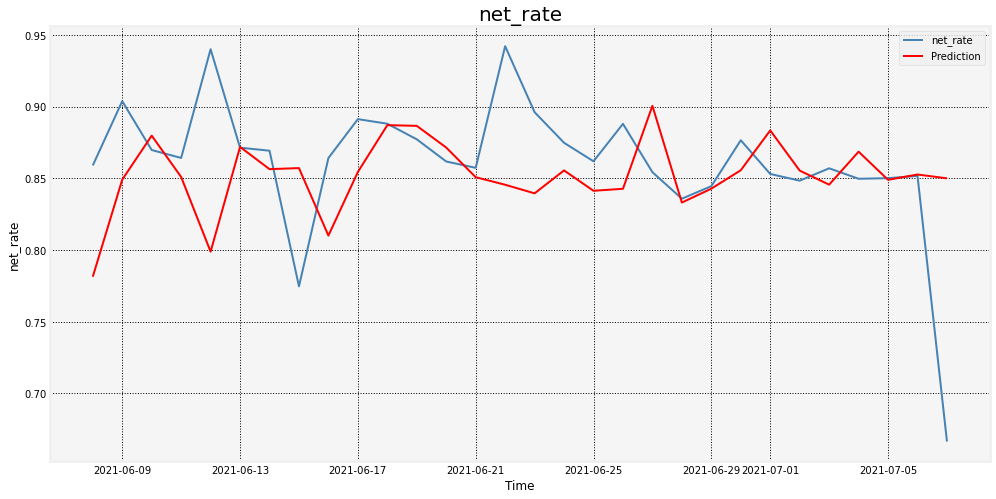

In [41]:
forecast = pd.DataFrame()
forecast['index'] = ran_val_data.index
forecast['forecast'] = yhat
forecast['actual'] = y
forecast = forecast.set_index('index')

# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()
# forecast = pd.concat([ran_val_data.index,y,yhat],axis=1)

# One step ahead prediction with RF

In [42]:
# finalize model and make a prediction for monthly births with random forest
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values
 
# load the dataset
series = ran_data
values = series.values
# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=7) # look back 7 days to make tomorrow's prediction
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = RandomForestRegressor(n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new prediction
row = values[-7:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print("Inputs: %s" % (row)) # one week prior
print("Tomorrow's predicted value: %f" % (yhat[0]))

Inputs: [0.85307139 0.848371   0.85700378 0.84971528 0.8501157  0.85173485
 0.66648263]
Tomorrow's predicted value: 0.745167


# GMV Deep Dive

In [57]:
gmv_rate = pd.read_csv('gmv_order_mart_com&can.csv')
gmv_rate = gmv_rate[gmv_rate.grass_date != '9999-01-01']
gmv_rate.reset_index(inplace=True, drop=True)
gmv_rate['grass_date'] = pd.to_datetime(gmv_rate['grass_date'])
gmv_rate = gmv_rate.set_index(['grass_date'])
gmv_rate = gmv_rate.sort_index()
gmv_rate

,gmv,gmv_usd,order_fe_status
grass_date,,,
2015-05-22,4920.0,1.502180e+02,CANCELLED
2015-05-23,10279.0,3.138396e+02,CANCELLED
2015-05-24,8000.0,2.442569e+02,CANCELLED
2015-05-25,6600.0,2.015120e+02,COMPLETED
2015-05-25,23469.0,7.165582e+02,CANCELLED
...,...,...,...
2021-07-05,120009564.0,3.755638e+06,CANCELLED
2021-07-06,444598639.5,1.401707e+07,COMPLETED
2021-07-06,130839835.0,4.090176e+06,CANCELLED


In [58]:
cancel_gmv = gmv_rate[gmv_rate['order_fe_status']=='CANCELLED']
cancel_gmv.drop(['order_fe_status','gmv'], axis=1, inplace=True)

complete_gmv = gmv_rate[gmv_rate['order_fe_status']=='COMPLETED']
complete_gmv.drop(['order_fe_status','gmv'], axis=1, inplace=True)

C:\Users\mizte\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [59]:
gmvr = pd.DataFrame()
gmvr['date'] = gmv_rate.index.copy()
gmvr = gmvr.set_index(['date'])
gmvr['complete'] = complete_gmv
gmvr['cancel'] = cancel_gmv
gmvr.fillna(0, inplace=True)
gmvr = gmvr[gmvr.index.duplicated(keep='first')]
rate_gmv = gmvr['complete']/(gmvr['complete']+gmvr['cancel'])
gmvr['gmv_rate'] = rate_gmv
gmvr = gmvr.drop(['complete','cancel'],axis=1)

In [46]:
gmv_net = net_rate.copy()
gmv_net['gmv_rate'] = gmvr
gmv_net.dropna(inplace=True)
sax_data = gmv_net.copy()
sax_train_data = gmv_net[:-plen]
sax_val_data = gmv_net[-plen:]
sax_train_data

,net_rate,gmv_rate
date,,
2015-05-25,0.266667,0.219495
2015-06-02,0.222222,0.153927
2015-06-03,0.285714,0.432642
2015-06-04,0.724138,0.611353
2015-06-05,0.473684,0.182049
...,...,...
2021-06-03,0.860099,0.811376
2021-06-04,0.884038,0.817524
2021-06-05,0.936399,0.857167


In [47]:
sax_model = auto_arima(sax_train_data[['net_rate']],exogenous=sax_train_data[['gmv_rate']], start_p=0, start_q=0,
                           max_p=2, max_q=2, m=7,
                           start_P=0,start_Q=0,max_Q=2,max_P=2,seasonal=True,d=1, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(sax_model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-6751.162, Time=0.25 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-7082.434, Time=0.79 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-7430.463, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-6753.161, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-7432.452, Time=0.79 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-7430.465, Time=1.87 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-7428.456, Time=1.59 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-7507.830, Time=1.23 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-7507.166, Time=2.38 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-7506.187, Time=2.66 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-7506.193, Time=2.89 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-7079.173, Time=0.93 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=-7505.378, Time=1.60 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=-7503.910, Time=1.78 sec
 ARIMA(0,1,2)(0,0,0

In [48]:
sax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2133
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood                3769.012
Date:                            Tue, 13 Jul 2021   AIC                          -7526.023
Time:                                    12:41:24   BIC                          -7492.035
Sample:                                         0   HQIC                         -7513.584
                                           - 2133                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gmv_rate       0.9896      0.005    197.129      0.000       0.980       0.999
ar.L1          0.2480      0.018     13.754      0.000       0.213       0.283
ma.L1         -0.8840      0.009    -97.514      0.000      -0.902      -0.866
ar.S.L7        0.0317      0.015      2.069      0.039       0.002       0.062
ar.S.L14       0.0957      0.016      6.037      0.000       0.065       0.127
sigma2         0.0017   2.01e-05     84.765      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             77283.14
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             2.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# Forecast
saxmodel = SARIMAX(sax_train_data['net_rate'], order=(1,1,1), seasonal_order=(2,0,0,7), exog=sax_train_data['gmv_rate'])
saxmodel_fit = saxmodel.fit()

C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


C:\Users\mizte\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<AxesSubplot:title={'center':'Validation Net Rate'}, xlabel='date'>

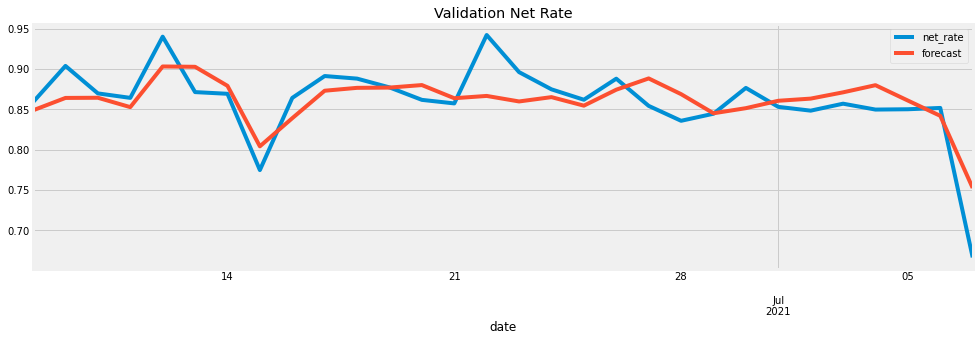

In [50]:
pred_sax = model_fit.get_forecast(steps=len(sarimax_val_data), exog=sax_val_data['gmv_rate']) # needs to know future gmv_rate
forecast = pd.DataFrame(pred_sax.predicted_mean)
forecast.index = sax_val_data.index
forecast = forecast.rename(columns={'predicted_mean':'forecast'})
pd.concat([sax_val_data['net_rate'],forecast],axis=1).plot(title = 'Validation Net Rate',figsize=(15, 4.5))

In [51]:
forecast['actual'] = sax_val_data['net_rate']
# Metrics

# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.000863
rmse,0.029369
mae,0.022095
mape,2.599743
mdae,0.014504
mdape,1.701296
